# Enrichment analysis and functional clustering

## Initialize environment

In [6]:
library(Seurat)
library(data.table)
library(tidyverse)
library(edgeR)
library(RColorBrewer)

In [2]:
whole <- readRDS("./data/whole_annot.rds")
edata <- round(AggregateExpression(whole, group.by = "sample")[[1]], 0)
pdata <- data.frame(
    row.names = colnames(edata),
    group = c(rep("LC", 2), rep("OC", 3), rep("OD", 3))
)
rm(whole)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3410923,182.2,5026618,268.5,5026618,268.5
Vcells,5999040,45.8,1128607612,8610.6,1407121202,10735.5


## edgeR based DEG detection

### Initialization

In [3]:
edata[1:6,]

,H12,H13,OC305,OC315,OC330,OD287,OD294,OD306
AL627309.1,34,13,22,13,7,16,26,19
AL669831.5,148,155,121,77,135,214,265,211
FAM87B,23,11,11,5,16,38,45,22
LINC00115,209,174,66,53,124,222,120,76
FAM41C,55,35,14,42,32,59,27,49
AL645608.1,19,2,13,37,12,37,76,50


In [52]:
saveRDS(edata, "./data/pseudoProfile.rds")

In [4]:
dge <- DGEList(counts = edata, group = factor(pdata$group))
design <- model.matrix(~ 0 + factor(pdata$group))
colnames(design) <- levels(factor(pdata$group))
rownames(design) <- colnames(edata)
cont <- makeContrasts(contrasts = c("OC-LC", "OD-LC"), levels = design)
dge <- dge[filterByExpr(dge, group = pdata$group), keep.lib.sizes = FALSE] %>%
    calcNormFactors() %>%
    estimateDisp(design)

In [24]:
fit <- glmFit(dge, design, robust = TRUE)

In [31]:
oc_degs <- glmLRT(fit, contrast = cont[, 1]) %>%
    topTags(n = Inf) %>%
    as.data.frame()
oc_degs <- data.table(
    gene = rownames(oc_degs),
    oc_degs,
    comparison = "OC"
)
od_degs <- glmLRT(fit, contrast = cont[, 2]) %>%
    topTags(n = Inf) %>%
    as.data.frame()
od_degs <- data.table(
    gene = rownames(od_degs),
    od_degs,
    comparison = "OD"
)

In [32]:
oc_degs %>% fwrite("./results/deg/oc_deg_raw.csv")
od_degs %>% fwrite("./results/deg/od_deg_raw.csv")

In [33]:
summary(decideTests(glmLRT(fit, contrast = cont[, 1]), lfc = 0.8))
summary(decideTests(glmLRT(fit, contrast = cont[, 2]), lfc = 0.8))

       -1*LC 1*OC
Down          291
NotSig      18588
Up            112

       -1*LC 1*OD
Down           93
NotSig      18802
Up             96

In [34]:
combined_degs <- rbind(oc_degs, od_degs)
head(combined_degs)

gene,logFC,logCPM,LR,PValue,FDR,comparison
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CFB,-2.380042,4.9325772,36.39723,1.609315e-09,3.056251e-05,OC
ADD2,-3.390302,0.6189666,34.80413,3.645993e-09,3.179255e-05,OC
GRB7,-2.712419,1.6735239,34.18078,5.022256e-09,3.179255e-05,OC
MYRF,-2.217055,3.3462160,33.58188,6.832629e-09,3.243962e-05,OC
CNTN4,1.837558,3.9573465,31.41990,2.078399e-08,7.894176e-05,OC
CCBE1,-1.845260,4.9125925,30.58806,3.190504e-08,9.163770e-05,OC


In [37]:
combined_degs <- combined_degs[order(PValue, -logFC), .(
    gene, logFC, FDR, PValue, logP = -log10(FDR), comparison,
    trend = ifelse(abs(logFC) > 0.8 & FDR < 0.05,
                   ifelse(logFC > 0.8, "up", "down"),
                   "ns"
                  )
)]
fwrite(combined_degs, "./results/deg/combined_deg.csv")

In [3]:
combined_degs <- fread("./results/deg/combined_deg.csv")

### Venn diagram

In [4]:
library(VennDiagram)
library(RColorBrewer)

载入需要的程辑包：grid

载入需要的程辑包：futile.logger



In [10]:
venn.diagram(
    x = list(
        combined_degs[comparison == "OC" & trend == "up", gene],
        combined_degs[comparison == "OD" & trend == "up", gene]
    ),
    category.names = c("Obese control", "Obese diabetic"),
    filename = "./plots/deg/venn/venn_up.png",
    output = TRUE,
    imagetype = "png",
    fill = brewer.pal(3, "Set1")[c(2, 1)],
    cex = 1.2,
    cat.cex = 1.2,
    cat.default.pos = "text"
)

[1] 1

In [9]:
venn.diagram(
    x = list(
        combined_degs[comparison == "OC" & trend == "down", gene],
        combined_degs[comparison == "OD" & trend == "down", gene]
    ),
    category.names = c("Obese control", "Obese diabetic"),
    filename = "./plots/deg/venn/venn_down.pngg",
    output = TRUE,
    imagetype = "png",
    fill = brewer.pal(3, "Set1")[c(2, 1)],
    cex = 1,
    cat.cex = 1,
    cat.default.pos = "text"
)

[1] 1

### Heatmap

In [165]:
deg_union <- combined_degs[trend != "ns", gene]
deg4hm <- combined_degs[gene %in% deg_union,]
deg4hm %>% head()

gene,logFC,FDR,PValue,logP,comparison,trend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
PPP1R1B,-4.127039,7.374846e-07,3.883337e-11,6.132247,OD,down
EGFL6,-2.871125,3.929734e-06,4.138522e-10,5.405637,OD,down
SAMD5,-3.157539,5.114589e-06,8.079494e-10,5.291189,OD,down
CFB,-2.380042,3.056251e-05,1.609315e-09,4.514811,OC,down
AMBP,-8.492244,1.072016e-05,2.257946e-09,4.969799,OD,down
ADD2,-3.390302,3.179255e-05,3.645993e-09,4.497675,OC,down


In [169]:
deg4hm <- dcast(deg4hm, gene ~ comparison, value.var = c("logFC", "trend")) %>%
    mutate(
        spec_label = ifelse(
            trend_OC == trend_OD,
            "both",
            ifelse(
                trend_OC == "ns" | trend_OD == "ns",
                "spec",
                "counter"
            )
        )
    ) %>%
    mutate(
        trend_label = ifelse(
            spec_label == "both",
            sprintf("both_%s", trend_OC),
            ifelse(
                trend_OC == "ns",
                ifelse(
                    trend_OD == "up",
                    "od_up",
                    "od_down"
                ),
                ifelse(
                    trend_OC == "up",
                    "oc_up",
                    "oc_down"
                )
            )
        )
    ) %>% select(gene, logFC_OC, logFC_OD, trend_label) %>%
    arrange(trend_label, logFC_OC)
fwrite(deg4hm, "./results/deg/deg4hm.csv")

In [104]:
library(ComplexHeatmap)

ComplexHeatmap version 2.13.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



载入程辑包：‘ComplexHeatmap’


The following object is masked from ‘package:latticeExtra’:

    dendrogramGrob




In [170]:
hm_mat <- data.frame(
    row.names = deg4hm$gene,
    obese_control = deg4hm$logFC_OC,
    obese_diabetic = deg4hm$logFC_OD
)

In [171]:
hm_cut <- lapply(unique(deg4hm$trend_label), \(x) {match(x, deg4hm$trend_label)})
hm_cut

[[1]]
[1] 1

[[2]]
[1] 60

[[3]]
[1] 107

[[4]]
[1] 339

[[5]]
[1] 404

[[6]]
[1] 438

In [265]:
hm_ind <- c(
    474, 65, 24, 367, 430, 462, 438, 64, 36,
    47, 405, 79, 353, 53, 373, 463, 257, 137,
    139, 300, 149, 269, 209, 175, 170
)

In [258]:
color_vec <- brewer.pal(6, "Paired")
names(color_vec) <- unique(deg4hm$trend_label)
color_vec %>% as.list()

$both_down
[1] "#A6CEE3"

$both_up
[1] "#1F78B4"

$oc_down
[1] "#B2DF8A"

$oc_up
[1] "#33A02C"

$od_down
[1] "#FB9A99"

$od_up
[1] "#E31A1C"

In [277]:
hm <- Heatmap(
    hm_mat,
    show_row_names = FALSE,
    column_names_rot = 45,
    cluster_rows = FALSE,
    cluster_columns = FALSE,
    row_title = NULL,
    name = "DEG",
    left_annotation =  rowAnnotation(
        trend = deg4hm$trend_label,
        col = list(trend = color_vec),
        show_annotation_name = FALSE
    ),
    right_annotation = rowAnnotation(
        foo = anno_mark(
            at = hm_ind,
            labels = rownames(hm_mat)[hm_ind]
        )
    ),
)
png("./plots/deg/heatmap.png", width = 9, height = 12, units = "in", res = 300)
draw(hm)
dev.off()
svg("./plots/deg/heatmap.svg", width = 9, height = 12)
draw(hm)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

png 
  2

In [272]:
png("./plots/deg/heatmap.png", width = 9, height = 12, units = "in", res = 300)
draw(hm)
dev.off()

png 
  2

## Run GSEA

### Initialization

In [79]:
library(fgsea)
library(msigdbr)
library(lattice)
library(latticeExtra)


载入程辑包：‘latticeExtra’


The following object is masked from ‘package:ggplot2’:

    layer




In [54]:
kegg_gs <- msigdbr(category = "C2", subcategory = "CP:KEGG")
setDT(kegg_gs)
kegg_gs[1:3,]

gs_cat,gs_subcat,gs_name,gene_symbol,entrez_gene,ensembl_gene,human_gene_symbol,human_entrez_gene,human_ensembl_gene,gs_id,gs_pmid,gs_geoid,gs_exact_source,gs_url,gs_description
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C2,CP:KEGG,KEGG_ABC_TRANSPORTERS,ABCA1,19,ENSG00000165029,ABCA1,19,ENSG00000165029,M11911,,,hsa02010,http://www.genome.jp/kegg/pathway/hsa/hsa02010.html,ABC transporters
C2,CP:KEGG,KEGG_ABC_TRANSPORTERS,ABCA10,10349,ENSG00000154263,ABCA10,10349,ENSG00000154263,M11911,,,hsa02010,http://www.genome.jp/kegg/pathway/hsa/hsa02010.html,ABC transporters
C2,CP:KEGG,KEGG_ABC_TRANSPORTERS,ABCA12,26154,ENSG00000144452,ABCA12,26154,ENSG00000144452,M11911,,,hsa02010,http://www.genome.jp/kegg/pathway/hsa/hsa02010.html,ABC transporters


In [55]:
kegg_gs <- kegg_gs[,.(
    gs_name = str_replace_all(str_remove(gs_name, "^KEGG_"), "\\_", " "),
    gene_symbol
)] %>% split(x = .$gene_symbol, f = .$gs_name)

In [56]:
gobp_gs <- msigdbr(category = "C5", subcategory = "GO:BP")
setDT(gobp_gs)
gobp_gs[1:3,]

gs_cat,gs_subcat,gs_name,gene_symbol,entrez_gene,ensembl_gene,human_gene_symbol,human_entrez_gene,human_ensembl_gene,gs_id,gs_pmid,gs_geoid,gs_exact_source,gs_url,gs_description
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C5,GO:BP,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,AASDHPPT,60496,ENSG00000149313,AASDHPPT,60496,ENSG00000149313,M29088,,,GO:0009256,http://amigo.geneontology.org/amigo/term/GO:0009256,"The chemical reactions and pathways involving 10-formyltetrahydrofolate, the formylated derivative of tetrahydrofolate. [GOC:ai]"
C5,GO:BP,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,ALDH1L1,10840,ENSG00000144908,ALDH1L1,10840,ENSG00000144908,M29088,,,GO:0009256,http://amigo.geneontology.org/amigo/term/GO:0009256,"The chemical reactions and pathways involving 10-formyltetrahydrofolate, the formylated derivative of tetrahydrofolate. [GOC:ai]"
C5,GO:BP,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,ALDH1L2,160428,ENSG00000136010,ALDH1L2,160428,ENSG00000136010,M29088,,,GO:0009256,http://amigo.geneontology.org/amigo/term/GO:0009256,"The chemical reactions and pathways involving 10-formyltetrahydrofolate, the formylated derivative of tetrahydrofolate. [GOC:ai]"


In [278]:
saveRDS(gobp_gs, "~/bioresource/genesets/gobp.rds")
saveRDS(kegg_gs, "~/bioresource/genesets/kegg.rds")

In [57]:
gobp_gs <- gobp_gs[,.(
    gs_name = str_replace_all(str_remove(gs_name, "^GOBP_"), "\\_", " "),
    gene_symbol
)] %>% split(x = .$gene_symbol, f = .$gs_name)

### GSEA

In [69]:
oc_gsea <- fgsea(
    gobp_gs, combined_degs[comparison == "OC",]
    [order(-logFC), .(gene, logFC)] %>% deframe(),
    minSize = 3, eps = 0.0
     )[order(padj)]

od_gsea <- fgsea(
    gobp_gs, combined_degs[comparison == "OD",]
    [order(-logFC), .(gene, logFC)] %>% deframe(),
    minSize = 3, eps = 0.0
     )[order(padj)]

Warning message in fgseaMultilevel(...):
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”


In [211]:
oc_gsea[padj < 0.05, pathway]

[1] "IMMUNE RESPONSE"                                               
 [2] "CELL ACTIVATION"                                               
 [3] "ADAPTIVE IMMUNE RESPONSE"                                      
 [4] "BUNDLE OF HIS CELL TO PURKINJE MYOCYTE SIGNALING"              
 [5] "INFLAMMATORY RESPONSE"                                         
 [6] "REGULATION OF IMMUNE SYSTEM PROCESS"                           
 [7] "REGULATION OF VERY LOW DENSITY LIPOPROTEIN PARTICLE REMODELING"
 [8] "DEFENSE RESPONSE"                                              
 [9] "NEGATIVE REGULATION OF HYDROGEN PEROXIDE METABOLIC PROCESS"    
[10] "CYTOKINE MEDIATED SIGNALING PATHWAY"

In [101]:
fwrite(oc_gsea, "./results/enrich/oc_gsea.csv")
fwrite(od_gsea, "./results/enrich/od_gsea.csv")
# fwrite(combined_gsea[pathway %in% sigpath_union,], "./combined_gsea.csv")

In [3]:
oc_gsea <- fread("./results/enrich/oc_gsea.csv")
od_gsea <- fread("./results/enrich/od_gsea.csv")

In [4]:
sigpath_union <- union(oc_gsea[padj < 0.05, pathway], od_gsea[padj < 0.05, pathway])

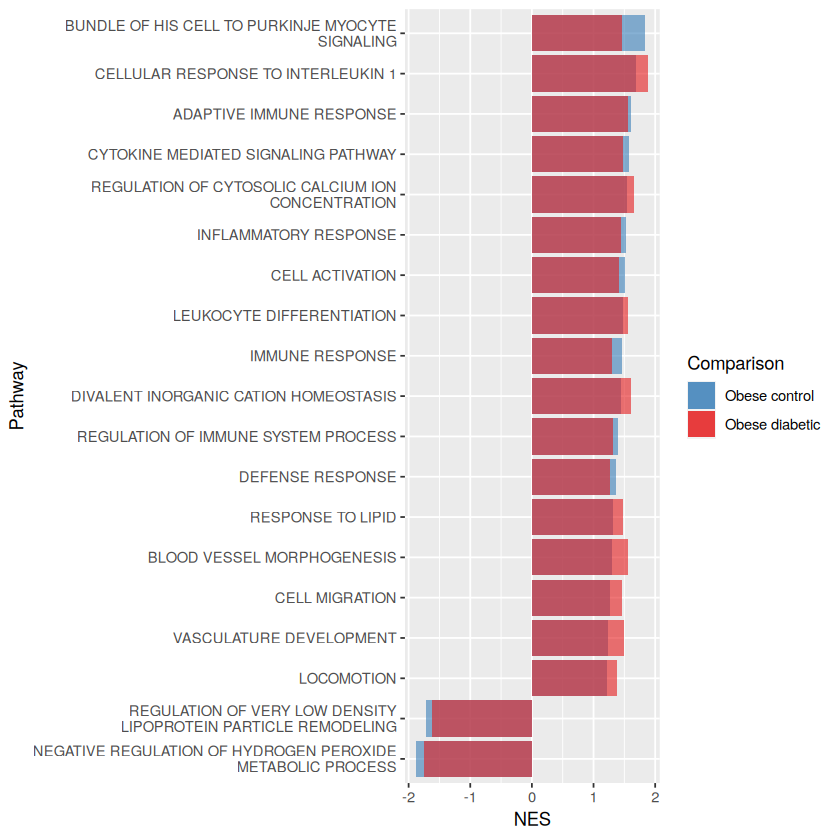

In [8]:
p <- ggplot(data = NULL, aes(x = NES, y = fct_reorder(pathway, NES))) +
    geom_col(aes(fill = "Obese control"), alpha = 0.6,
             data = oc_gsea[pathway %in% sigpath_union]) +
    geom_col(aes(fill = "Obese diabetic"), alpha = 0.6,
             data = od_gsea[pathway %in% sigpath_union]) +
    scale_y_discrete(label = \(x){str_wrap(x, width = 40)}) +
    scale_fill_manual(name = "Comparison",
                      values = brewer.pal(3, "Set1")[c(2, 1)]) +
    ylab("Pathway")
ggsave("./plots/enrich/gsea.svg", p, width = 8, height = 6)
p

In [220]:
combined_gsea <- rbind(oc_gsea %>% mutate(comparison = "OC"),
                       od_gsea %>% mutate(comparison = "OD"))

In [221]:
gsea_bar <- combined_gsea[,.(pathway, padj, logP = -log10(padj), NES, comparison)]

In [226]:
gsea_bar

pathway,padj,logP,NES,comparison,color
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
IMMUNE RESPONSE,0.000618541,3.2086315,1.456363,OC,#9E0142
CELL ACTIVATION,0.002299200,2.6384233,1.506135,OC,#E95C47
ADAPTIVE IMMUNE RESPONSE,0.016523000,1.7819111,1.611244,OC,#F8E48D
BUNDLE OF HIS CELL TO PURKINJE MYOCYTE SIGNALING,0.016523000,1.7819111,1.830118,OC,#F8E48D
INFLAMMATORY RESPONSE,0.016523000,1.7819111,1.531314,OC,#F8E48D
REGULATION OF IMMUNE SYSTEM PROCESS,0.016523000,1.7819111,1.400891,OC,#F8E48D
REGULATION OF VERY LOW DENSITY LIPOPROTEIN PARTICLE REMODELING,0.016523000,1.7819111,-1.721712,OC,#F8E48D
DEFENSE RESPONSE,0.019832019,1.7026331,1.368063,OC,#F4E890
NEGATIVE REGULATION OF HYDROGEN PEROXIDE METABOLIC PROCESS,0.033082820,1.4803975,-1.872084,OC,#DDF199


In [232]:
color_breaks <- do.breaks(range(gsea_bar$logP), 50)
color_vec <- rev(colorRampPalette(brewer.pal(10, "Spectral"))(50))
gsea_bar <- gsea_bar[padj < 0.05, .(pathway, padj, logP, NES, comparison,
                        color = level.colors(logP, at = color_breaks,
                                             col.regions = color_vec))]
gsea_bar

pathway,padj,logP,NES,comparison,color
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
IMMUNE RESPONSE,0.000618541,3.208632,1.456363,OC,#9E0142
CELL ACTIVATION,0.002299200,2.638423,1.506135,OC,#E95C47
ADAPTIVE IMMUNE RESPONSE,0.016523000,1.781911,1.611244,OC,#F8E48D
BUNDLE OF HIS CELL TO PURKINJE MYOCYTE SIGNALING,0.016523000,1.781911,1.830118,OC,#F8E48D
INFLAMMATORY RESPONSE,0.016523000,1.781911,1.531314,OC,#F8E48D
REGULATION OF IMMUNE SYSTEM PROCESS,0.016523000,1.781911,1.400891,OC,#F8E48D
REGULATION OF VERY LOW DENSITY LIPOPROTEIN PARTICLE REMODELING,0.016523000,1.781911,-1.721712,OC,#F8E48D
DEFENSE RESPONSE,0.019832019,1.702633,1.368063,OC,#F4E890
NEGATIVE REGULATION OF HYDROGEN PEROXIDE METABOLIC PROCESS,0.033082820,1.480397,-1.872084,OC,#DDF199


In [244]:
svg("./plots/enrich/oc_sig.svg", width = 8, height = 6)
dotplot(pathway ~ NES, gsea_bar[comparison == "OC"],
        groups = color, cex = 1,
        prepanel = function(x, y){
            list(ylim = levels(reorder(y, x)))
        },
        panel = function(x, y, groups, ..., subscripts){
            fill <- groups[subscripts]
            panel.dotplot(x, reorder(y, x), col = fill, ...)
        },
        legend = list(right = list(
            fun = draw.colorkey,
            args = list(key = list(
                col = color_vec, at = color_breaks
            ), draw = FALSE)
        )), main = "Obese control significant pathways"
)
dev.off()

png 
  2

In [245]:
svg("./plots/enrich/od_sig.svg", width = 8, height = 6)
dotplot(pathway ~ NES, gsea_bar[comparison == "OD"],
        groups = color, cex = 1,
        prepanel = function(x, y){
            list(ylim = levels(reorder(y, x)))
        },
        panel = function(x, y, groups, ..., subscripts){
            fill <- groups[subscripts]
            panel.dotplot(x, reorder(y, x), col = fill, ...)
        },
        legend = list(right = list(
            fun = draw.colorkey,
            args = list(key = list(
                col = color_vec, at = color_breaks
            ), draw = FALSE)
        )), main = "Obese diabetic significant pathways"
)
dev.off()

png 
  2